In [1]:
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import utils

In [3]:
content_paths = dict(
    omori = "./content/omori.png",
    buildings = "./content/buildings.jpg"
)
style_paths = dict(
    great_wave_kanagawa = "./style/The_Great_Wave_off_Kanagawa.jpg",
    pillars_of_creation = "./style/Pillars_of_creation.jpg",
    starry_night = "./style/Starry_Night.jpg",
    scream = "./style/Scream.jpg",
    omori = "./style/omori.png",
    pointillism = "./style/pointillism.jpg"
)

In [4]:
content_images = {k: utils.load_img(v) for k, v in content_paths.items()}
style_images = {k: utils.load_img(v) for k, v in style_paths.items()}

In [5]:
content_name = 'buildings'  # @param ['omori', 'buildings']
style_name = 'great_wave_kanagawa'  # @param ['great_wave_kanagawa', 'pillars_of_creation', 'starry_night', 'scream', 'omori', 'pointillism']

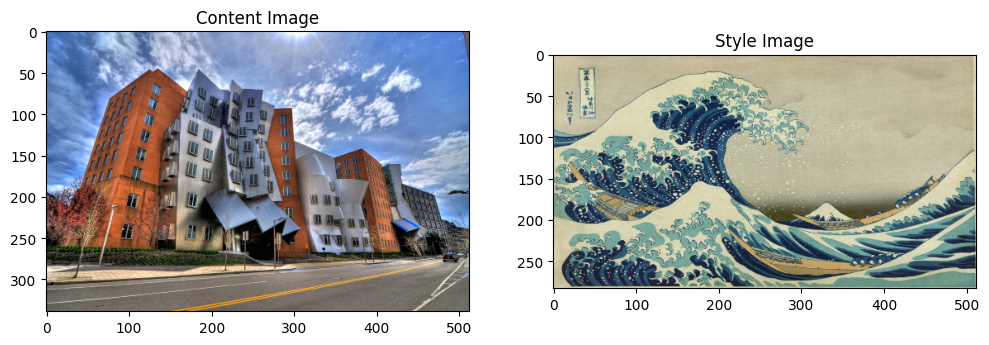

In [6]:
content_image = content_images[content_name]
style_image = style_images[style_name]

plt.subplot(1, 2, 1)
utils.imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
utils.imshow(style_image, 'Style Image')

In [7]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)

In [8]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('church', 0.39984107),
 ('alp', 0.14647025),
 ('castle', 0.11598348),
 ('monastery', 0.054783996),
 ('picket_fence', 0.041201025)]

In [9]:
content_layers_dict = dict(
    block5_conv2 = ['block5_conv2']
)

style_layers_dict = dict(
    layers_1 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'],
    layers_2 = ['block1_conv2',
                'block2_conv2',
                'block3_conv3',
                'block4_conv1',
                'block5_conv1'],
    layers_1_1 = ['block1_conv1'],
    layers_1_2 = ['block1_conv2'],
    layers_2_1 = ['block2_conv1'],
    layers_2_2 = ['block2_conv2'],
    layers_3_1 = ['block3_conv1'],
    layers_3_3 = ['block3_conv3'],
    layers_4_1 = ['block4_conv1'],
    layers_5_1 = ['block5_conv1']
)


In [10]:
style_layers_name = 'layers_1'  # @param ['layers_1', 'layers_2', 'layers_1_1', 'layers_1_2', 'layers_2_1', 'layers_2_2', 'layers_3_1', 'layers_3_3', 'layers_4_1', 'layers_5_1']
style_layers = style_layers_dict[style_layers_name]
content_layers_name = 'block5_conv2'  # @param ['block5_conv2']
content_layers = content_layers_dict[content_layers_name]

In [11]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [12]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [13]:
dimension = "512"  # @param ['128', '224', '256', '384', '512']
style_image = tf.image.resize(style_image, (int(dimension), style_image.shape[2]), preserve_aspect_ratio=True)

In [14]:
random_crop = "No"  # @param['Yes', 'No']
img = style_image

if random_crop == "Yes":
  style_image = tf.image.crop_and_resize(style_image, boxes=[[0.0, 0.0, np.random.random(), np.random.random()]], crop_size=[style_image.shape[1], style_image.shape[2]], box_indices=[0])


  plt.subplot(1, 2, 1)
  utils.imshow(img, 'Original Image')

  plt.subplot(1, 2, 2)
  utils.imshow(style_image, 'Cropped Image')

In [15]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [16]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [17]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [18]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

In [19]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [20]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [21]:
style_weight=1e-2
content_weight=1e4

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [23]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [24]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [25]:
total_variation_weight=30

In [26]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [27]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
stylized_image = tf.Variable(content_image)

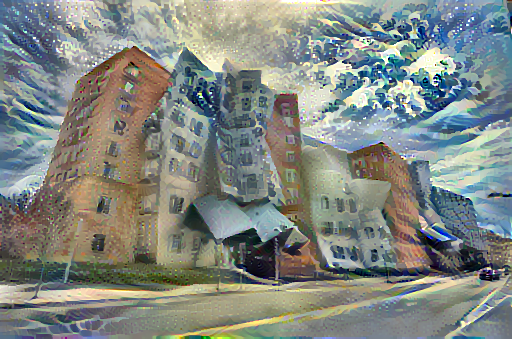

Train step: 1000
Total time: 66.2


In [28]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(stylized_image)
    print(str(step) + ", ", end='', flush=True)
  display.clear_output(wait=True)
  display.display(utils.tensor_to_image(stylized_image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


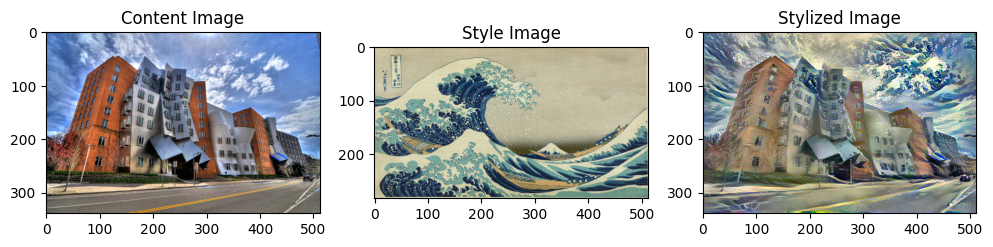

In [29]:
plt.subplot(1, 3, 1)
utils.imshow(content_image, 'Content Image')

plt.subplot(1, 3, 2)
utils.imshow(style_image, 'Style Image')

plt.subplot(1, 3, 3)
utils.imshow(stylized_image, 'Stylized Image')